In [45]:
!mkdir ./data/
!mkdir ./figures/

mkdir: cannot create directory ‘./data/’: File exists
mkdir: cannot create directory ‘./figures/’: File exists


## Importations

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision import transforms

cuda = torch.cuda.is_available()

In [47]:
from dataset import PairedDataset
from loss import ContrastiveLoss
from model import FeatureExtractor, SiameseNet
from utils import train_epoch, test_epoch

## Load and explore data

In [48]:
mean, std = 0.1307, 0.3081

tf = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset = MNIST('./data/', train=True, download=True, transform=tf)
test_dataset = MNIST('./data/', train=False, download=True, transform=tf)

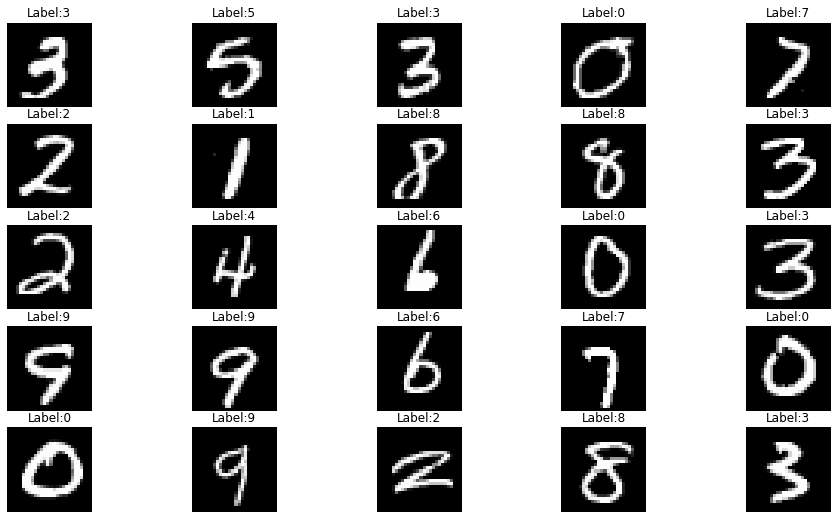

In [49]:
fig, axs = plt.subplots(5, 5, figsize=(16, 9))
for i in range(5):
   for j in range(5):
     k = np.random.randint(0, len(train_dataset), 1)[0]
     im, lab = train_dataset[k]
     #im = 1. - im
     axs[i,j].imshow(im[0], cmap='gray')
     axs[i,j].set_title('Label:' + str(lab))
     axs[i,j].axis('off')
plt.savefig('./figures/mnist_dataset.png')
#plt.show()

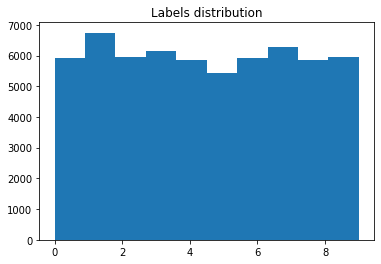

In [50]:
labels = [train_dataset[i][1] for i in range(len(train_dataset))]
plt.title('Labels distribution')
plt.hist(labels, bins=len(set(labels)))
plt.show()

In [51]:
print('Number of images:', len(train_dataset))
print('Number of unique labels:', len(set(labels)))
print('Number of images per label:', len(train_dataset) // len(set(labels)))

Number of images: 60000
Number of unique labels: 10
Number of images per label: 6000


## Prepare dataloader, model and optimizer

In [52]:
# model hyperparameters
M, k = 3, 2
lambd = 1.
margin = .6

# training hyperparameters
n_epochs = 10
batch_size = 128
lr = 1e-3
log_interval = 100

In [53]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

siamese_train_dataset = PairedDataset(train_dataset)
siamese_test_dataset = PairedDataset(test_dataset)

siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [54]:
feature_extractor = FeatureExtractor(M, k)
model = SiameseNet(feature_extractor)

if cuda:
    model.cuda()

criterion = ContrastiveLoss(margin, M, k, lambd)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

## Training

In [33]:
val_loss, dist_pos, dist_neg = test_epoch(siamese_test_loader, model, criterion, cuda)
message = 'Initialization. Validation set: Average loss: {:.4f}, Mean distance (positive): {:.4f}, Mean distance (negative): {:.4f}'.format(val_loss, dist_pos, dist_neg)
print(message)

train_losses, val_losses = [], []
pos_losses, neg_losses = [], []

for epoch in range(n_epochs):
    scheduler.step()

    train_loss = train_epoch(siamese_train_loader, model, criterion, optimizer, cuda)
    val_loss, dist_pos, dist_neg = test_epoch(siamese_test_loader, model, criterion, cuda)

    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}; Validation set: Average loss: {:.4f}, Mean distance (positive): {:.4f}, Mean distance (negative): {:.4f}'.format(epoch + 1, n_epochs, train_loss, val_loss, dist_pos, dist_neg)
    print(message)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    pos_losses.append(dist_pos)
    neg_losses.append(dist_neg)

Initialization. Validation set: Average loss: 0.0747, Mean distance (positive): 0.0029, Mean distance (negative): 0.0039


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1/10. Train set: Average loss: 0.0087; Validation set: Average loss: 0.0031, Mean distance (positive): 0.0090, Mean distance (negative): 0.4153
Epoch: 2/10. Train set: Average loss: 0.0025; Validation set: Average loss: 0.0019, Mean distance (positive): 0.0067, Mean distance (negative): 0.4882
Epoch: 3/10. Train set: Average loss: 0.0015; Validation set: Average loss: 0.0019, Mean distance (positive): 0.0072, Mean distance (negative): 0.5946
Epoch: 4/10. Train set: Average loss: 0.0011; Validation set: Average loss: 0.0014, Mean distance (positive): 0.0049, Mean distance (negative): 0.4867
Epoch: 5/10. Train set: Average loss: 0.0008; Validation set: Average loss: 0.0011, Mean distance (positive): 0.0040, Mean distance (negative): 0.4979
Epoch: 6/10. Train set: Average loss: 0.0007; Validation set: Average loss: 0.0013, Mean distance (positive): 0.0048, Mean distance (negative): 0.4855
Epoch: 7/10. Train set: Average loss: 0.0005; Validation set: Average loss: 0.0013, Mean dista

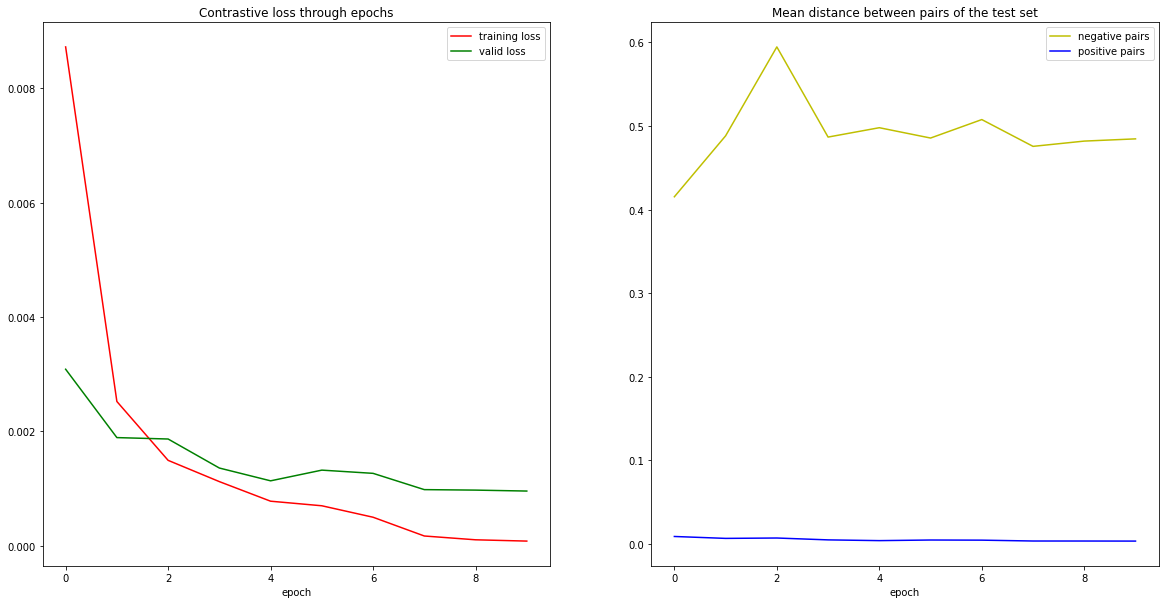

In [34]:
plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.title('Contrastive loss through epochs')
plt.xlabel('epoch')
plt.plot(train_losses, label='training loss', c='r')
plt.plot(val_losses, label='valid loss', c='g')
plt.legend()

plt.subplot(122)
plt.title('Mean distance between pairs of the test set')
plt.xlabel('epoch')
plt.plot(neg_losses, label='negative pairs', c='y')
plt.plot(pos_losses, label='positive pairs', c='b')
plt.legend()

plt.savefig('./figures/metrics.png')
#plt.show()

In [42]:
torch.save(model.state_dict(), './model.pt')

## Visualization and evaluation

In [55]:
model.load_state_dict(torch.load('./model.pt'))
model.eval()

SiameseNet(
  (embedding_net): FeatureExtractor(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=256, out_features=6, bias=True)
    )
  )
)

In [56]:
def extract_embeddings(dataloader):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), M, k))
        labels = np.zeros(len(dataloader.dataset))
        l = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            emb = model.get_embedding(images)
            emb = emb.view((emb.size(0), M, k))
            embeddings[l:l+len(images)] = emb.data.cpu().numpy()
            labels[l:l+len(images)] = target.numpy()
            l += len(images)
    return embeddings, labels

train_embeddings, train_labels = extract_embeddings(train_loader)
test_embeddings, test_labels = extract_embeddings(test_loader)

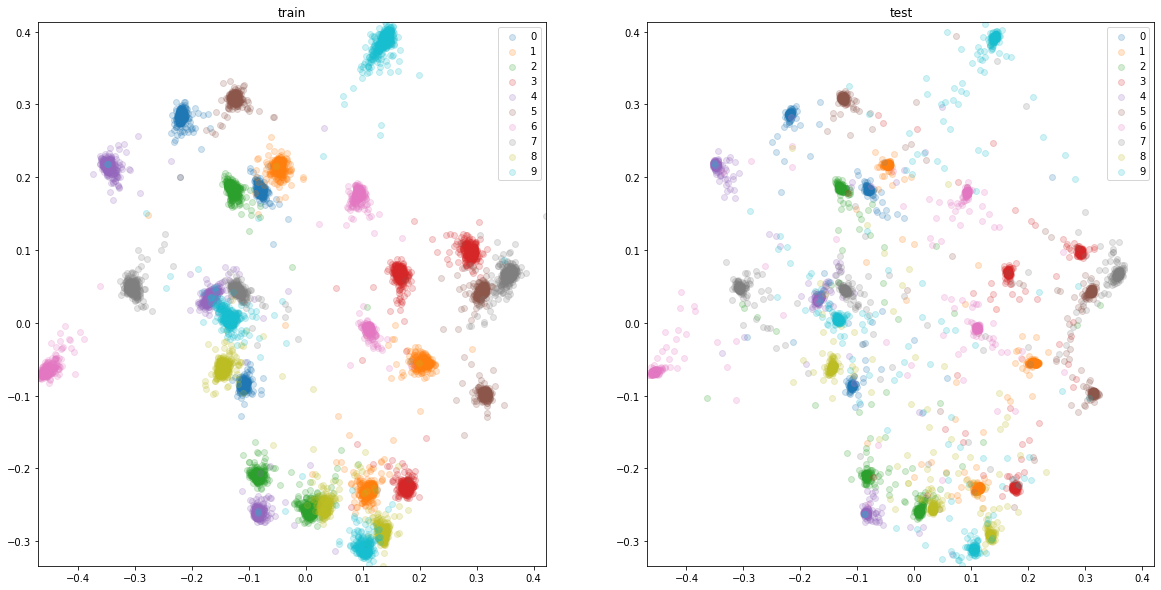

In [57]:
plt.figure(figsize=(20, 10))

plt.subplot(121)
for i in range(10):
    inds = np.where(train_labels==i)[0]
    tmp = train_embeddings[inds,:,:].reshape((-1, 2))
    plt.scatter(tmp[:,0], tmp[:,1], alpha=0.2, label=str(i))
plt.title('train')
plt.legend()
xmin, xmax = np.min(train_embeddings[:,:,0]), np.max(train_embeddings[:,:,0])
ymin, ymax = np.min(train_embeddings[:,:,1]), np.max(train_embeddings[:,:,1])
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.subplot(122)
for i in range(10):
    inds = np.where(test_labels==i)[0]
    tmp = test_embeddings[inds,:,:].reshape((-1, 2))
    plt.scatter(tmp[:,0], tmp[:,1], alpha=0.2, label=str(i))
plt.title('test')
plt.legend()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.savefig('./figures/point_cloud_visualization.png')
#plt.show()

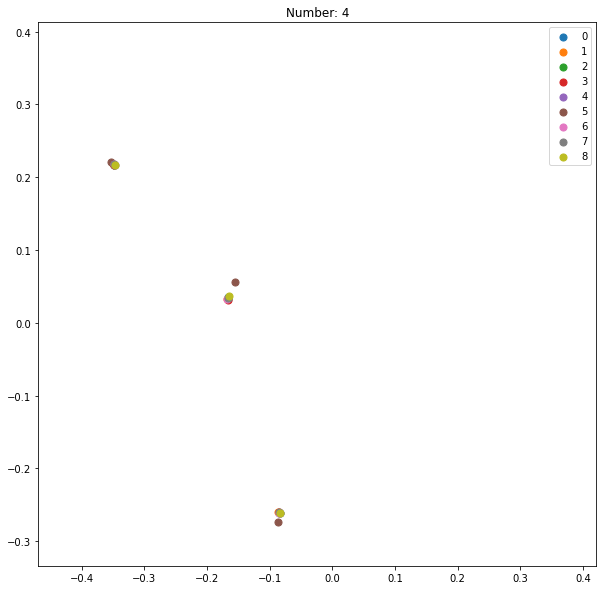

In [58]:
i = 4
inds = np.where(test_labels==i)[0]

plt.figure(figsize=(10, 10))
for j in range(9):
    plt.scatter(test_embeddings[inds[j],:,0], test_embeddings[inds[j],:,1], alpha=1., s=50, label=str(j))
plt.legend()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title('Number: '+str(i))
plt.savefig('./figures/feature_visualization.png')
#plt.show()

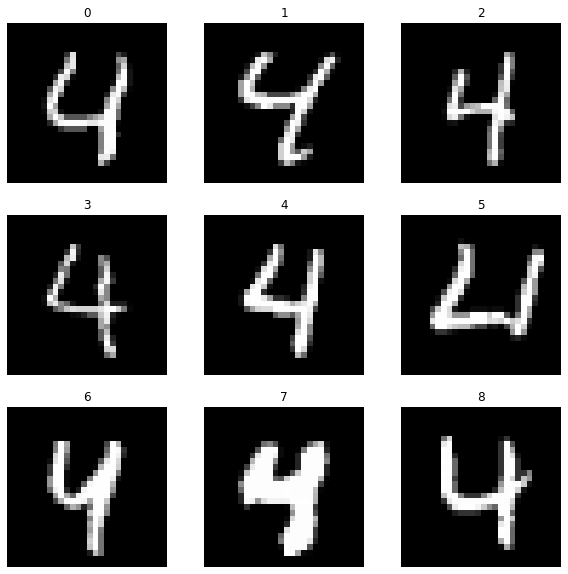

In [59]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
k = 0
for i in range(3):
   for j in range(3):
     im, _ = test_dataset[inds[k]]
     axs[i,j].imshow(im[0], cmap='gray')
     axs[i,j].set_title(str(k))
     axs[i,j].axis('off')
     k += 1
plt.savefig('./figures/feature_visualization_images.png')
#plt.show()

In [60]:
n_train, n_test = len(train_labels), len(test_labels)

classifier = KNeighborsClassifier(n_neighbors=50)
a, b = train_embeddings.reshape((n_train, -1)), train_labels.reshape((n_train, 1))
classifier.fit(a, b)
print('Accuracy on test set:', 
      accuracy_score(test_labels.reshape((n_test, 1)), 
                     classifier.predict(test_embeddings.reshape((n_test, -1)))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


Accuracy on test set: 0.9941
